# A/A/B-эксперимент для приложения стартапа, который продаёт продукты питания

### Введение

#### Краткое описание, цели и задачи проекта

Краткое описание: поступила идея от дизайнеров поменять шрифты во всём приложении, решение будет принято по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

Есть две основные задачи, которые можно разбить на промежуточные:

1) Нужно изучить, как ведут себя пользователи мобильного приложения. Для этого рассмотрим:
* Воронку продаж. 
* Как пользователи доходят до покупки. 
* Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

2) Исследуем результаты A/A/B-эксперимента по изменению шрифта
* Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Таким образом мы проверим корректность формирования контрольных групп для А/А теста.
* Проверим есть ли статистически значимые различия между контрольными группами и группой с измененным шрифтом.

Цель проекта - выяснить, какой шрифт лучше.

#### Описание данных

Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Откроем файл с данными и изучим общую информацию

Загрузим нужные библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

Изучим общую информацию.

In [2]:
data = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Посмотрим какие есть события.

In [5]:
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Приступим к предобработке.

### Подготовим данные

#### Переименуем колонки и посмотрим на общую информацию

In [6]:
data = data.rename(
columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 'EventTimestamp':'event_timestamp','ExpId':'exp_id'})

Посмотрим на общую информацию.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

Пропусков нет. Типы данных впорядке, название столбцов подкорректировали.

#### Добавим столбец даты и времени, а также отдельный столбец дат

In [9]:
# добавим столбец даты и времени
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')

In [10]:
# добавим столбец с датой
data['date'] = data['date_time'].dt.date

In [11]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


#### Посмотрим есть ли дубликаты

In [12]:
data.duplicated().sum()

413

Дубликатов много, посмотрим, как распределены дубликаты по разным событиям и группам тестирования.

In [13]:
# посчитаем долю дубликатов в каждом событии
(data[data.duplicated()].groupby('event_name')
                         ['event_name'].count() / data.groupby('event_name')['event_name'].count() * 100)

event_name
CartScreenAppear           0.147434
MainScreenAppear           0.087245
OffersScreenAppear         0.036305
PaymentScreenSuccessful    0.568298
Tutorial                   3.231939
Name: event_name, dtype: float64

Наибольшая доля дубликатов у Tutorial. Это раздел или страница с инструкцией пользователя. Возможно, люди сразу открывают инструкцию в двух вкладках, чтобы в одной прочитать сразу, а в другой оставить, если чуть позже она понадобится. Но для построения воронки и A/A/B теста нам достаточно того, что человек открыл раздел 1 раз. 

In [14]:
# посчитаем долю дубликатов в каждой группе
data[data.duplicated()].groupby('exp_id')['exp_id'].count() / data.groupby('exp_id')['exp_id'].count() * 100

exp_id
246    0.153168
247    0.160102
248    0.192427
Name: exp_id, dtype: float64

In [15]:
# доля дубликатов от общего количества строк маленькая
data.duplicated().sum()/len(data)*100

0.16917493425526162

По группам доли очень маленькие и все примерно ровно.\
В целом, можно сделать вывод, что дубликаты можно удалить. Их доли не высокие, и нам будет достаточно того, что человек сделал определенное действие 1 раз.

In [16]:
data = data.drop_duplicates()

### Изучим и проверим данные

#### Соберем общую информацию о данных

Ответим на три вопроса: 
* Сколько всего событий?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?

In [17]:
print(f'Всего {len(data)} событий.')

Всего 243713 событий.


In [18]:
users_count = data['device_id_hash'].nunique()

In [19]:
print(f'Всего {users_count} уникальных пользователей.')

Всего 7551 уникальных пользователей.


In [20]:
even_per_user = len(data)/users_count 

In [21]:
print(f'На одного пользователя приходится {round(even_per_user,2)} событий.')

На одного пользователя приходится 32.28 событий.


#### Изучим данные и распределение событий по датам

In [22]:
min_date = data['date'].min()
max_date = data['date'].max()
print(f'Мы имеем данные с {min_date} по {max_date}.')

Мы имеем данные с 2019-07-25 по 2019-08-07.


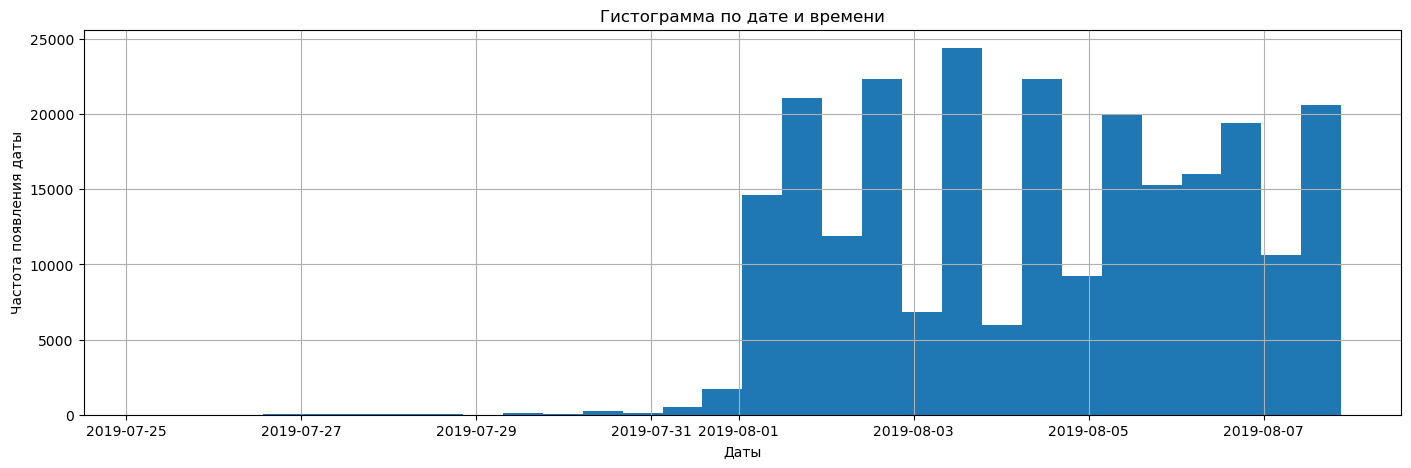

In [23]:
plt.figure(figsize=(17, 5))
plt.title('Гистограмма по дате и времени')
plt.xlabel('Даты')
plt.ylabel('Частота появления даты')
data['date_time'].hist(bins=30)
plt.show()

По графику видно, что до начала августа крайне мало событий приходилось на каждую дату. 

In [24]:
data['date_time'].describe(datetime_is_numeric=True)

count                           243713
mean     2019-08-04 10:19:17.987665920
min                2019-07-25 04:43:36
25%                2019-08-02 14:36:45
50%                2019-08-04 11:51:00
75%                2019-08-06 06:56:24
max                2019-08-07 21:15:17
Name: date_time, dtype: object

Применив метод describe мы видим, что до обеденнного времени 2 августа было 25% событий.

Можно посчитать доли событий на каждую дату.

In [25]:
data.groupby('date')['date'].count().sort_values(ascending=False)/len(data)*100

date
2019-08-01    14.829328
2019-08-05    14.795271
2019-08-06    14.684485
2019-08-02    14.588471
2019-08-03    13.656227
2019-08-04    13.527387
2019-08-07    12.759270
2019-07-31     0.832947
2019-07-30     0.169051
2019-07-29     0.075499
2019-07-28     0.043083
2019-07-27     0.022568
2019-07-26     0.012720
2019-07-25     0.003693
Name: date, dtype: float64

Тут мы также видим, что почти все события в августе.

Для точности счета долей, можно посмотреть до какой даты и времени было 5% событий и 1% событий.

In [26]:
data['date_time'].quantile([0.05, 0.01])

0.05   2019-08-01 09:28:05.000
0.01   2019-07-31 22:02:31.120
Name: date_time, dtype: datetime64[ns]

В итоге, вывод такой, что события в июле можно отбросить. Получается, что отбросим менее 5% данных.

In [27]:
data_filtered = data.loc[data['date_time'].dt.month > 7]

In [28]:
print(f'После фильтрации количество событий сократилось на {round (100*(1 - len(data)/len(data_filtered)),2)} процентов.')

После фильтрации количество событий сократилось на -1.17 процентов.


Посмотрим на потери по уникальным пользователям в количественном и процентном соотношении.

In [29]:
unique_users_diff = round(100*(1 - data['device_id_hash'].nunique()/data_filtered['device_id_hash'].nunique()),2)

In [30]:
print(f'После фильтрации количество уникальных пользователей сократилось на {unique_users_diff } процентов.')

После фильтрации количество уникальных пользователей сократилось на -0.23 процентов.


In [31]:
unique_users_diff = data['device_id_hash'].nunique() - data_filtered['device_id_hash'].nunique()

In [32]:
print(f'В абсолютном выражение уникальных пользователей после фильтрации стало меньше на {unique_users_diff } человек.')

В абсолютном выражение уникальных пользователей после фильтрации стало меньше на 17 человек.


Потери небольшие, поэтому такая фильтрация допустима.

Проверим, как по экспериментальным группам распределно количество пользователей.

In [33]:
data_filtered.groupby('exp_id')['device_id_hash'].count()

exp_id
246    79302
247    77022
248    84563
Name: device_id_hash, dtype: int64

In [34]:
data_filtered.groupby('exp_id')['device_id_hash'].count() / len(data) * 100

exp_id
246    32.539093
247    31.603566
248    34.697780
Name: device_id_hash, dtype: float64

Доли пользователей в каждой группе от общего количества пользователей близки между собой.

### Изучим воронку событий

#### Посмотрим, какие события есть в логах, как часто они встречаются

In [35]:
data.groupby('event_name')['event_name'].count().sort_values(ascending = False)

event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

* Событие MainScreenAppear - это вход на главный раздел приложения. Логично, что это самое частое событие, так как с него все начинается.
* Событие OffersScreenAppear - это,скорее всего, вход на раздел со списком товаров. Идет после главной страницы и до корзины.
* Событие CartScreenAppear - это просмотр корзины, куда покупатели отложили товары перед оплатой.
* Событие PaymentScreenSuccessful - это окно с уведомлением об успешной оплате.
* Tutorial - это просмотр инструкции по работе приложения. Этот раздел наименее популярный, хотя идти он может после входа на главный раздел, если хочется начать формировать заказ, но не понятно как. Но это не обязательно, ведь открыть инструкцию можно на каком угодно шаге. Видимо приложение понятно пользователю и руководство чаще всего не нужно.

#### Посчитаем, сколько пользователей совершали каждое из этих событий хотябы раз

In [36]:
sections = data_filtered.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False).reset_index()
sections['proportion'] = round(sections['device_id_hash'] / data_filtered['device_id_hash'].nunique() * 100,2)
sections

,event_name,device_id_hash,proportion
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Исходя из логики, описанной в предыдущем параграфе можно составить такую цепочку событий:\
1)MainScreenAppear;\
2)OffersScreenAppear;\
3)CartScreenAppear;\
4)PaymentScreenSuccessful.\
Шаг Tutorial мы пропускаем, так как мало, кто заходит в этот раздел, а значит нет смысла при расчете воронки ставить его после первого шага. Более того, инструкцию могут открыть после любого шага.

#### Проанализируем воронку событий

Для этого сперва избавимся от шага Tutorial.

In [37]:
sections = sections.drop([4])
sections

,event_name,device_id_hash,proportion
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


Сперва посмотрим воронку, где расчет каждой доли идет от шага "MainScreenAppear". 

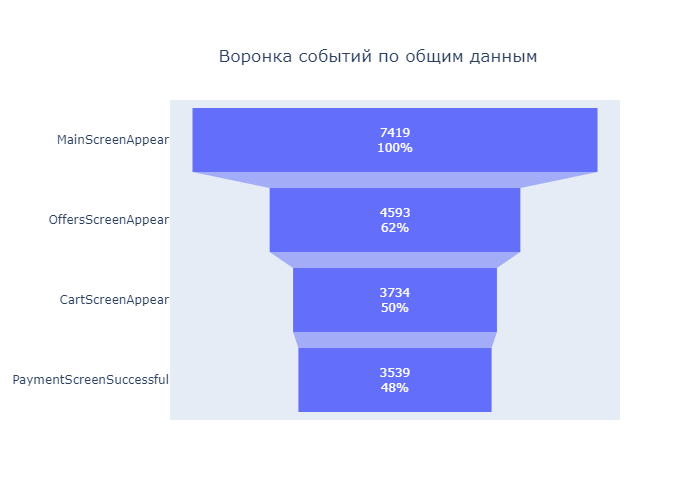

In [38]:
fig = go.Figure(go.Funnel(
    y = sections['event_name'],
    x = sections['device_id_hash'],
    textposition = "inside",
    textinfo = "value+percent initial"),
    )
fig.update_layout(
title={
        'text': "Воронка событий по общим данным",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show("png")

Уже тут ясно, что больше всего пользователей теряются на 1-ом шаге. Лишь 62% пользователей доходят до шага 2 `OffersScreenAppear`.\
Затем еще 12% от общего количества пользователей не доходят до шага `CartScreenAppear`.\
Почти все, кто дошли до шага просмотра корзины  в итоге что-то покупают. На шаге `CartScreenAppear` у нас 50% человек, а на шаге `PaymentScreenSuccessful` остается 48%, что является завершением воронки.\
Что-то приобрели хотябы раз 48% пользователей.

Теперь посчитаем воронку событий, где будем сравнивать количество пользователей текущего шага к предыдущему.

In [39]:
funnel=[]
for idx in range(len(sections['device_id_hash'])):
    if idx == 0:
        funnel.append(round(sections.loc[idx,'device_id_hash'] / sections.loc[idx,'device_id_hash'] * 100,2))
    else:
        funnel.append(round(sections.loc[idx,'device_id_hash'] / sections.loc[idx-1,'device_id_hash'] * 100,2))
funnel

[100.0, 61.91, 81.3, 94.78]

In [40]:
sections['funnel'] = funnel
sections

,event_name,device_id_hash,proportion,funnel
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


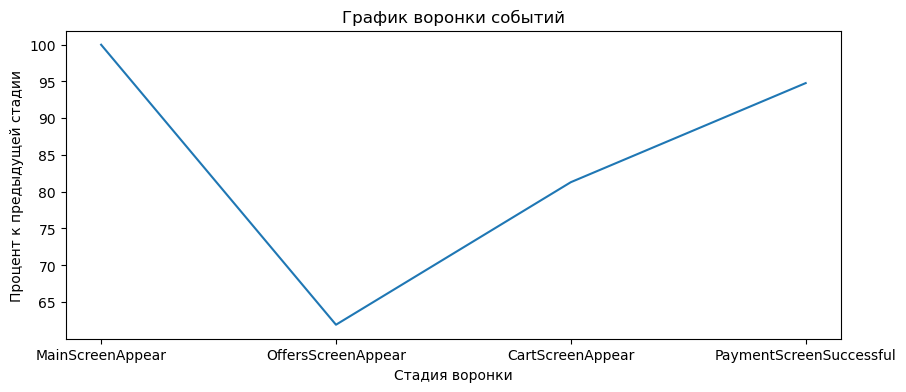

In [41]:
plt.figure(figsize=(10, 4))
plt.title('График воронки событий')
plt.xlabel('Стадия воронки')
plt.ylabel('Процент к предыдущей стадии')
plt.plot(sections['event_name'], sections['funnel'])
plt.show()

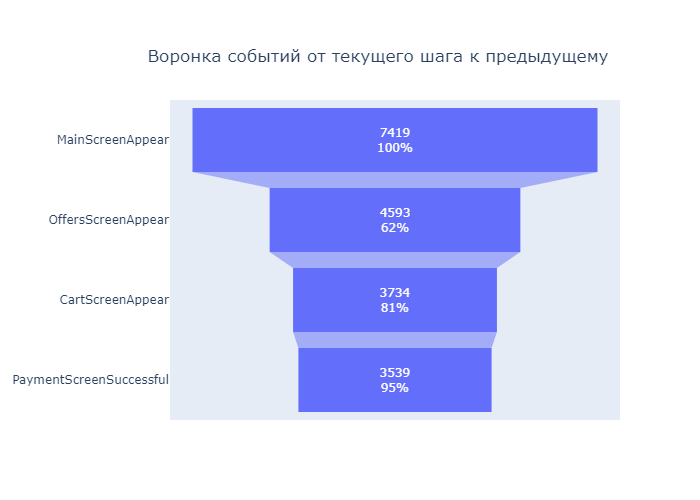

In [42]:
fig = go.Figure(go.Funnel(
    y = sections['event_name'],
    x = sections['device_id_hash'],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.update_layout(
title={
        'text': "Воронка событий от текущего шага к предыдущему",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show("png")

Если сравнивать текущий шаг к предыдущему, то можно нагляднее увидеть, то, что мы выше написали.\
На 1 шаге приложение теряет 48% пользователей, до второго шага доходит 62% от 1-го шага.\
На 2 шаге уходят примерно 19% пользователей от оставшися.
На 3 шаге как было ранее замечено почти нет потерь в числе пользователей.

#### Изучим результаты эксперимента

##### Подготовка к A/A-тесту

Посмотрим на количество пользователей в каждой группе.

In [43]:
data_filtered.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Есть 2 контрольные группы для А/А-эксперимента: 246 и 247. Для А/А успешного теста желательно, чтобы различие в количестве пользователей было не более 1%. Наши группы этому критерию почти соответствуют.

In [44]:
diff = (data_filtered.loc[data['exp_id'] == 247, 'device_id_hash'].nunique()
        /data_filtered.loc[data['exp_id'] == 246, 'device_id_hash'].nunique())

In [45]:
print(f'Группа 247 больше группы 246 на {diff-1:.1%}.')

Группа 247 больше группы 246 на 1.2%.


До удаления данных за июль группа 246 была больше группы 247 почти на 3%. Так что фильтрация не испортила ситуацию.

In [46]:
diff = (data.loc[data['exp_id'] == 246, 'device_id_hash'].count()
        /data.loc[data['exp_id'] == 247, 'device_id_hash'].count())

In [47]:
print(f' До фильтрации группа 246 больше группы 247 на {diff-1:.1%}.')

 До фильтрации группа 246 больше группы 247 на 2.9%.


Посмотрим есть ли те люди, которые попали в две или даже три группы одновременно.

In [48]:
unique_group_count = (
    data_filtered.groupby('device_id_hash', as_index=False)
    .agg({'exp_id': 'nunique'}))

unique_group_count = unique_group_count.loc[unique_group_count['exp_id']>1]

unique_group_count['device_id_hash'].count()

0

Таких нет. Можно сделать вывод, что контрольные группы сформированы корректно.

##### A/A-тест

Проведем z-тест. Сравним долю пользователей на каждом шаге от общего числа уникальных пользователей для групп 246 и 247. 
Покажем воронки для обоих групп.

In [49]:
# воронка для группы 246
sections_246 = data_filtered.loc[data_filtered['exp_id']==246].groupby(
               'event_name')['device_id_hash'].nunique().sort_values(ascending = False).reset_index()

In [50]:
funnel=[]
for idx in range(len(sections_246['device_id_hash'])):
        funnel.append(round(sections_246.loc[idx,'device_id_hash'] / sections_246.loc[0,'device_id_hash'] * 100,2))      

In [51]:
#создаем столбец с воронкой
sections_246['funnel'] = funnel

#удаляем строку с событием Tutorail
sections_246 = sections_246.drop([4])

sections_246

,event_name,device_id_hash,funnel
0,MainScreenAppear,2450,100.00
1,OffersScreenAppear,1542,62.94
2,CartScreenAppear,1266,51.67
3,PaymentScreenSuccessful,1200,48.98


In [52]:
# воронка для группы 247
sections_247 = data_filtered.loc[data_filtered['exp_id']==247].groupby(
               'event_name')['device_id_hash'].nunique().sort_values(ascending = False).reset_index()

In [53]:
funnel=[]
for idx in range(len(sections_247['device_id_hash'])):
        funnel.append(round(sections_247.loc[idx,'device_id_hash'] / sections_247.loc[0,'device_id_hash'] * 100,2))      

In [54]:
#создаем столбец с воронкой
sections_247['funnel'] = funnel

#удаляем строку с событием Tutorail
sections_247 = sections_247.drop([4])

sections_247

,event_name,device_id_hash,funnel
0,MainScreenAppear,2476,100.00
1,OffersScreenAppear,1520,61.39
2,CartScreenAppear,1238,50.00
3,PaymentScreenSuccessful,1158,46.77


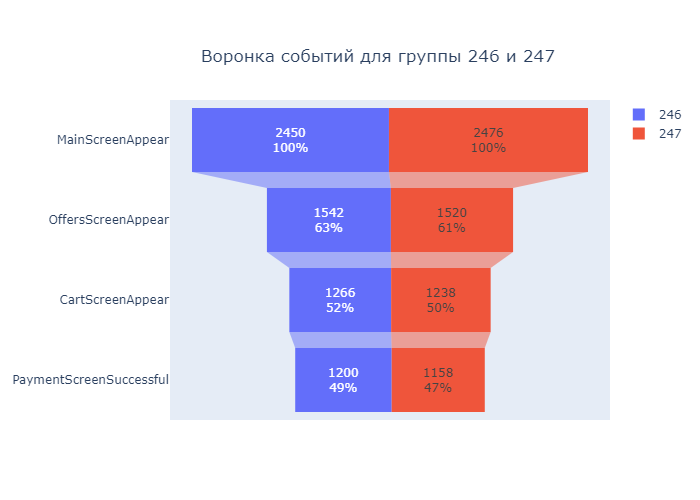

In [55]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = sections_246['event_name'],
    x = sections_246['device_id_hash'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = sections_247['event_name'],
    x = sections_247['device_id_hash'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.update_layout(
title={
        'text': "Воронка событий для группы 246 и 247",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show("png")

Уже замечаем, что воронки очень схожи. Начнем с того, что сравним доли людей, которые были на шаге MainScreenAppear. Создадим функцию, которую будем использовать для всех других долей. 

Применим поправку Бонферрони для корректировки уровня значимости. Так как у нас четыре теста по 4 гипотезы в каждом, то делим выбранный пороговый уровень 0.05 на 16.

* Нулевая гипотеза: доля пользователей перешедших на шаг MainScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [56]:
def proportion_test(alpha, df_1_stage, df_1_initial, df_2_stage, df_2_initial ):

    alpha = alpha  # критический уровень статистической значимости

    stage = np.array([df_2_stage, df_1_stage])
    initial = np.array([df_2_initial, df_1_initial])

# пропорция успехов в первой группе:
    p1 = stage[0]/initial[0]

# пропорция успехов в второй группе:
    p2 = stage[1]/initial[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (stage[0] + stage[1]) / (initial[0] + initial[1])

# разница пропорций в датасетах
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/initial[0] + 1/initial[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [57]:
proportion_test(0.05/16, 
                sections_246.loc[0,'device_id_hash'], 
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_247.loc[0,'device_id_hash'], 
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique())

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг OffersScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [58]:
proportion_test(0.05/16, 
                sections_246.loc[1,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_247.loc[1,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique())

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница в долях не оказалась статистически значимой.

Теперь посмотрим на следующий шаг.
* Нулевая гипотеза: доля пользователей перешедших на шаг CartScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [59]:
proportion_test(0.05/16, 
                sections_246.loc[2,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_247.loc[2,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique())

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Теперь сравним доли людей перешедших на шаг успешной оплаты.
* Нулевая гипотеза: доля пользователей перешедших на шаг PaymentScreenSuccessful одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [60]:
proportion_test(0.05/16, 
                sections_246.loc[3,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_247.loc[3,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique())

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Можно сделать вывод, что A/A-тест прошел успешно. При сравнении всех долей в группах 246 и 247 статистически значимых различий в долях обнаружено не было. Разница в количестве участников в группах составляет 1,2% и нет тех, кто попал в 2 или 3 группы сразу. Значит контрольные группы сформированы корректно. 

##### A/A/B-тест

Для оценки результатов эксперимента сравним доли пользователей на каждом шаге у каждой контрольной группы с экспериментальной.\
Начнем с рассчета воронки для экспериментальной группы.

In [61]:
sections_248 = data_filtered.loc[data_filtered['exp_id']==248].groupby(
               'event_name')['device_id_hash'].nunique().sort_values(ascending = False).reset_index()

In [62]:
funnel=[]
for idx in range(len(sections_248['device_id_hash'])):
        funnel.append(round(sections_248.loc[idx,'device_id_hash'] / sections_248.loc[0,'device_id_hash'] * 100,2)) 

In [63]:
#создаем столбец с воронкой
sections_248['funnel'] = funnel

#удаляем строку с событием Tutorail
sections_248 = sections_248.drop([4])

sections_248

,event_name,device_id_hash,funnel
0,MainScreenAppear,2493,100.00
1,OffersScreenAppear,1531,61.41
2,CartScreenAppear,1230,49.34
3,PaymentScreenSuccessful,1181,47.37


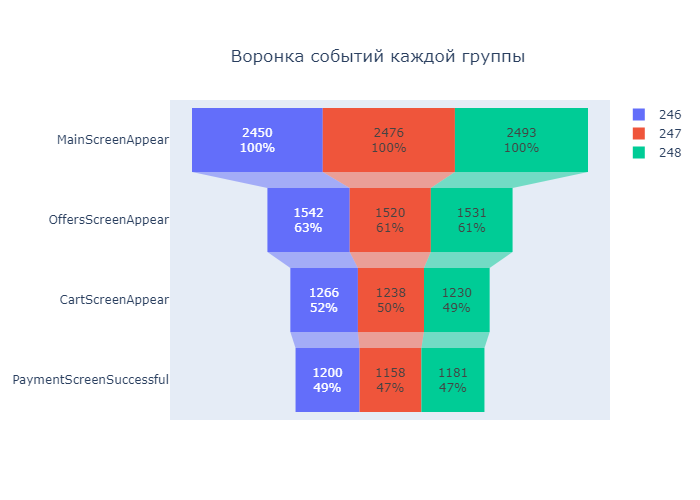

In [64]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = sections_246['event_name'],
    x = sections_246['device_id_hash'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = sections_247['event_name'],
    x = sections_247['device_id_hash'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = sections_248['event_name'],
    x = sections_248['device_id_hash'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(
title={
        'text': "Воронка событий каждой группы",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show("png")

Заметно, что большой разницы в долях у всех групп между собой нет.

**Сравним экспериментальную группу с группой 246.**
* Нулевая гипотеза: доля пользователей перешедших на шаг MainScreen одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [65]:
proportion_test(0.05/16, 
                sections_246.loc[0,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_248.loc[0,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг OffersScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [66]:
proportion_test(0.05/16, 
                sections_246.loc[1,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_248.loc[1,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг CartScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [67]:
proportion_test(0.05/16, 
                sections_246.loc[2,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_248.loc[2,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг PaymentScreenSuccessful одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [68]:
proportion_test(0.05/16, 
                sections_246.loc[3,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique(), 
                sections_248.loc[3,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы в долях пользователей на каждом шаге воронке у групп 248 и 246 нет.

**Сравним экспериментальную группу с группой 247.**


* Нулевая гипотеза: доля пользователей перешедших на шаг MainScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [69]:
proportion_test(0.05/16, 
                sections_247.loc[0,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique(), 
                sections_248.loc[0,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг OffersScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [70]:
proportion_test(0.05/16, 
                sections_247.loc[1,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique(), 
                sections_248.loc[1,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг CartScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [71]:
proportion_test(0.05/16, 
                sections_247.loc[2,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique(), 
                sections_248.loc[2,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг PaymentScreenSuccessful одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [72]:
proportion_test(0.05/16, 
                sections_247.loc[3,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique(), 
                sections_248.loc[3,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы в долях пользователей на каждом шаге воронке у групп 248 и 247 нет. Коэффициенты p-value всегда высокие. По результатам анализа можно сказать, что даже при пороговом значении 10%, все равно мы бы не нашли статистически значимой разницы.

**Сравним экспериментальную группу с объединенной экспериментальной группой, которая включает 246 и 247.**

Для этого посчитаем количество уникальных пользователей объединенной группы по шагам и общее количество уникальных пользователей в группах 246 и 247.

In [73]:
# воронка для групп 246 и 247 в сумме
sections_246_247 = sections_246
sections_246_247['device_id_hash'] = sections_246['device_id_hash']+sections_247['device_id_hash']
sections_246_247 = sections_246_247.drop('funnel', axis=1)
sections_246_247

,event_name,device_id_hash
0,MainScreenAppear,4926
1,OffersScreenAppear,3062
2,CartScreenAppear,2504
3,PaymentScreenSuccessful,2358


In [74]:
# общее число уникальных пользователей
unique_users_246_247 = (data_filtered.loc[data_filtered['exp_id']==246, 'device_id_hash'].nunique() + 
                        data_filtered.loc[data_filtered['exp_id']==247, 'device_id_hash'].nunique())
unique_users_246_247

4997

Начнем с самого первого шага воронки. 
* Нулевая гипотеза: доля пользователей перешедших на шаг MainScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [75]:
proportion_test(0.05/16, 
                sections_246_247.loc[0,'device_id_hash'],
                unique_users_246_247, 
                sections_248.loc[0,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Теперь можем изучать различие в долях объединенной контрольной группы и экспериментальной.
* Нулевая гипотеза: доля пользователей перешедших на шаг OffersScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [76]:
proportion_test(0.05/16, 
                sections_246_247.loc[1,'device_id_hash'],
                unique_users_246_247,  
                sections_248.loc[1,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг CartScreenAppear одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [77]:
proportion_test(0.05/16, 
                sections_246_247.loc[2,'device_id_hash'],
                unique_users_246_247, 
                sections_248.loc[2,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* Нулевая гипотеза: доля пользователей перешедших на шаг PaymentScreenSuccessful одинаковая в обоих группах. Альтернативная гипотеза: доля пользователей разная в обоих группах.

In [78]:
proportion_test(0.05/16, 
                sections_246_247.loc[3,'device_id_hash'],
                unique_users_246_247, 
                sections_248.loc[3,'device_id_hash'],
                data_filtered.loc[data_filtered['exp_id']==248, 'device_id_hash'].nunique())

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам сравнения долей пользователей на каждом этапе экспериментальной группы и объединенной контрольной группы делаем вывод, что нет статистически значимых различий.

##### Вывод по результатам A/A/B-теста

Мы провели A/A тест,сравнив четыре доли двух контрольных групп между собой. Проверили 4 гипотезы, получили 4 p-value, все оказались выше порога. Так что различий в контрольных группах мы не нашли. Контрольные группы сформированы корректно.\
Мы провели А/A/B, сравнив две контрольные группы по очереди с экспериментальной. Проверили 4 гипотезы для каждого сравнения. Итого 8 гипотез. Все 8 p-value оказались выше порога. Получается, что статистически значимой разницы между группами нет.\
Провели A/B тест, где сравнили экспериментальную группу с объединенной группой 246 и 247. Таким образом, проверены еще 4 гипотезы и оснований их отвергать нет, p-value высокие.\
Таким образом, было проверено 16 гипотез в 4 тестах.\
Не обнаружено значимого влияния измененного шрифта на воронку. Нет причин менять шрифт.\
P-value превысили порог в 5% с запасом, учитывая поправку Бонферрони. Даже если бы мы взяли порог в 10%, то ничего бы не поменялось ни для одной из гипотез.\
Выбор порогового значения в 0.05 обсуловлен тем, что если бы мы взяли уровень значимости 0.1, то, к примеру, p-value 0.09 оказалось бы ниже порога. Пришлось бы считать, что доли статистически различаются. Но это достаточно высокая вероятность. Вероятность получить одинаковые доли 9 раз из 100. Таким образом, уровень 0.1 не кажется подходящим, чтобы сказать, что новый шрифт действительно лучше или хуже текущего. 

### Общие выводы по результатам работы

* Из данных для дальнейшего анализа были удалены логи за июль, так как таких событий крайне мало.
* При расчете воронки, а значит и результатов теста, не использовался шаг Tutorial. Мы его не рассматриваем, так как он может идти после любого шага, и этот раздел имеет крайне мало посетителей по сравнению с другими событиями. 
* Воронки для всех трех рассматриваемых групп имеют примерно одинаковые доли на каждом шаге между группами.
* A/A - тест пройден успешно:

В группах 246 и 247 статистически значимых различий в долях обнаружено не было;\
Разница в количестве участников в группах составляет 1,2%;\
Нет тех, кто попал в 2 или 3 группы сразу. 
* A/A/B - тест показывает, что нет статистически значимых различий между группами 248 и 247, 248 и 246, а также 248 и 246+248.

**Итоговый вывод заключается в том, что не обнаружено существенного различия в воронках экспериментальной и контрольных групп. Поэтому нет причин менять шрифт.**